# Analyze meta teacher

In [2]:
import sys
sys.path.append('../')

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from lift.environments.gym_envs import NpGymEnv
from lift.environments.teacher_envs import TeacherEnv, ConditionedTeacher
from lift.environments.rollout import rollout

from lift.teacher import load_teacher
from configs import BaseConfig

In [4]:
config = BaseConfig()

teacher = load_teacher(config, meta=True)


MetaSAC teacher loaded


## Eval rollout

In [5]:
# generate traj
def eval_teacher_rollout(
    teacher, 
    env_noise, 
    env_noise_slope, 
    teacher_noise, 
    teacher_noise_slope, 
    n_steps=3000,
):
    env = NpGymEnv("FetchReachDense-v2", max_episode_steps=100)
    env = TeacherEnv(
        env, 
        noise_range=[env_noise, env_noise], 
        noise_slope_range=[env_noise_slope, env_noise_slope], 
        append_obs=False,
    )

    conditioned_teacher = ConditionedTeacher(
        teacher, 
        noise_range=[teacher_noise, teacher_noise], 
        noise_slope_range=[teacher_noise_slope, teacher_noise_slope], 
        alpha_range=[1., 1.],
    )
    conditioned_teacher.reset()
    
    data = rollout(
        env,
        conditioned_teacher,
        n_steps=n_steps,
        terminate_on_done=False,
        reset_on_done=True,
        random_pertube_prob=0.,
        action_noise=0.,
    )
    return data

In [6]:
# eval teacher with different meta variables in the same environment
np.random.seed(0)

env_noise = 0.
env_noise_slope = 0.

num_rows = 8
num_cols = 8
teacher_noises = torch.linspace(0., 1., steps=num_rows)
teacher_noise_slopes = torch.linspace(0., 1., steps=num_cols)

eval_data_1 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_data_1[i][j] = eval_teacher_rollout(
            teacher,
            env_noise, 
            env_noise_slope,
            teacher_noise,
            teacher_noise_slope,
        )

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 827.61item/s]


In [7]:
# eval teacher with different meta variables in the same environment
np.random.seed(0)

env_noise = 1.
env_noise_slope = 1.

num_rows = 8
num_cols = 8
teacher_noises = torch.linspace(0., 1., steps=num_rows)
teacher_noise_slopes = torch.linspace(0., 1., steps=num_cols)

eval_data_2 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_data_2[i][j] = eval_teacher_rollout(
            teacher,
            env_noise, 
            env_noise_slope,
            teacher_noise,
            teacher_noise_slope,
        )

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 845.58item/s]


In [8]:
# compute aggregate stats
def compute_stats(eval_data, func):
    num_rows = len(eval_data)
    num_cols = len(eval_data[0])
    return np.array([[func(eval_data[i][j]) for j in range(num_cols)] for i in range(num_rows)])

def compute_mean_reward(data):
    return data["rwd"].mean()

def compute_cum_reward(data):
    return data["rwd"].sum() / data["done"].sum()

def compute_reward_std(data):
    return data["rwd"].std()

def compute_eps_len(data):
    return len(data["done"]) / data["done"].sum()

def compute_act_abs(data):
    return np.abs(data["act"]).mean()

def compute_act_mean(data):
    return data["act"].mean()

def compute_act_std(data):
    return data["act"].std()

In [9]:
eval_rwd_mean_1 = compute_stats(eval_data_1, compute_mean_reward)
eval_rwd_std_1 = compute_stats(eval_data_1, compute_reward_std)
eval_act_mean_1 = compute_stats(eval_data_1, compute_act_mean)
eval_act_std_1 = compute_stats(eval_data_1, compute_act_std)
eval_act_abs_1 = compute_stats(eval_data_1, compute_act_abs)

eval_rwd_mean_2 = compute_stats(eval_data_2, compute_mean_reward)
eval_rwd_std_2 = compute_stats(eval_data_2, compute_reward_std)
eval_act_mean_2 = compute_stats(eval_data_2, compute_act_mean)
eval_act_std_2 = compute_stats(eval_data_2, compute_act_std)
eval_act_abs_2 = compute_stats(eval_data_2, compute_act_abs)

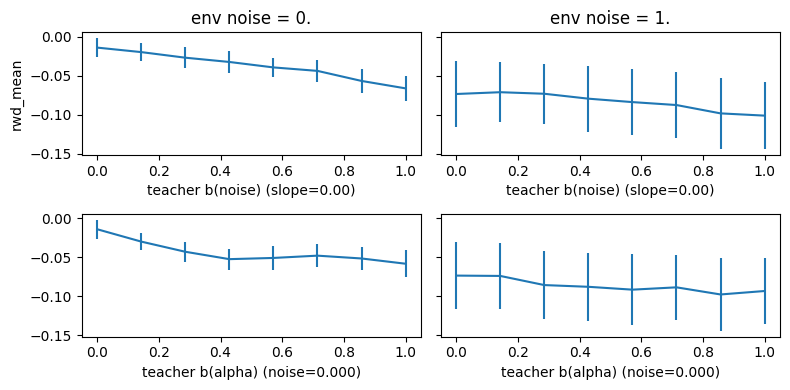

In [10]:
# compare reward
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharey="row")

alpha_ref_idx = 0
noise_ref_idx = 0

ax[0,0].errorbar(
    teacher_noises, 
    eval_rwd_mean_1[:,alpha_ref_idx].flatten(), 
    yerr=eval_rwd_std_1[:,alpha_ref_idx].flatten()
)

ax[0,1].errorbar(
    teacher_noises, 
    eval_rwd_mean_2[:,alpha_ref_idx].flatten(), 
    yerr=eval_rwd_std_2[:,alpha_ref_idx].flatten()
)

ax[1,0].errorbar(
    teacher_noise_slopes, 
    eval_rwd_mean_1[noise_ref_idx,:].flatten(), 
    yerr=eval_rwd_std_1[noise_ref_idx,:].flatten()
)

ax[1,1].errorbar(
    teacher_noise_slopes, 
    eval_rwd_mean_2[noise_ref_idx,:].flatten(), 
    yerr=eval_rwd_std_2[noise_ref_idx,:].flatten()
)

ax[0,0].set_xlabel(f"teacher b(noise) (slope={teacher_noise_slopes[alpha_ref_idx]:.2f})")
ax[0,0].set_ylabel("rwd_mean")
ax[0,0].set_title("env noise = 0.")

ax[0,1].set_xlabel(f"teacher b(noise) (slope={teacher_noise_slopes[alpha_ref_idx]:.2f})")
ax[0,1].set_title("env noise = 1.")

ax[1,0].set_xlabel(f"teacher b(alpha) (noise={teacher_noises[noise_ref_idx]:.3f})")
ax[1,1].set_xlabel(f"teacher b(alpha) (noise={teacher_noises[noise_ref_idx]:.3f})")

plt.tight_layout()
plt.show()

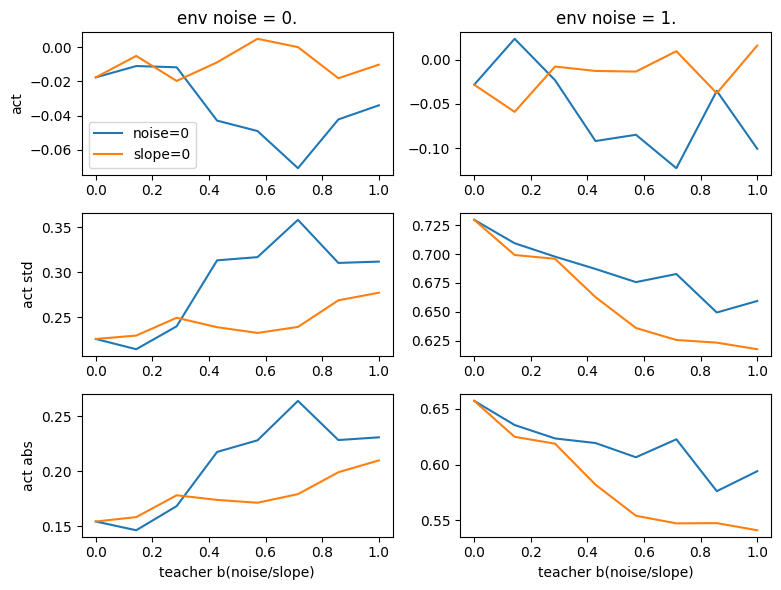

In [11]:
# compare actions
fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex="row")
ax[0, 0].plot(teacher_noises, eval_act_mean_1[:,0].flatten(), label="noise=0")
ax[0, 0].plot(teacher_noise_slopes, eval_act_mean_1[0,:].flatten(), label="slope=0")

ax[0, 1].plot(teacher_noises, eval_act_mean_2[:,0].flatten(), label="alpha=0")
ax[0, 1].plot(teacher_noise_slopes, eval_act_mean_2[0,:].flatten(), label="noise=0")

ax[1, 0].plot(teacher_noises, eval_act_std_1[:,0].flatten(), label="alpha=0")
ax[1, 0].plot(teacher_noise_slopes, eval_act_std_1[0,:].flatten(), label="noise=0")

ax[1, 1].plot(teacher_noises, eval_act_std_2[:,0].flatten(), label="alpha=0")
ax[1, 1].plot(teacher_noise_slopes, eval_act_std_2[0,:].flatten(), label="noise=0")

ax[2, 0].plot(teacher_noises, eval_act_abs_1[:,0].flatten(), label="alpha=0")
ax[2, 0].plot(teacher_noise_slopes, eval_act_abs_1[0,:].flatten(), label="noise=0")

ax[2, 1].plot(teacher_noises, eval_act_abs_2[:,0].flatten(), label="alpha=0")
ax[2, 1].plot(teacher_noise_slopes, eval_act_abs_2[0,:].flatten(), label="noise=0")

ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

ax[-1, 0].set_xlabel("teacher b(noise/slope)")
ax[-1, 1].set_xlabel("teacher b(noise/slope)")

ax[0, 0].set_ylabel("act")
ax[1, 0].set_ylabel("act std")
ax[2, 0].set_ylabel("act abs")
ax[0, 0].legend()
plt.tight_layout()
plt.show()

In [12]:
def plot_heat_map(eval_stats, ax, xlabel, ylabel):
    df = pd.DataFrame(
        eval_stats, 
        index=[round(i, 2) for i in teacher_noises.tolist()], 
        columns=[round(i, 2) for i in teacher_noise_slopes.tolist()], 
    )
    sns.heatmap(df, annot=True, cbar=False, fmt=".2f", cmap="Blues", ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

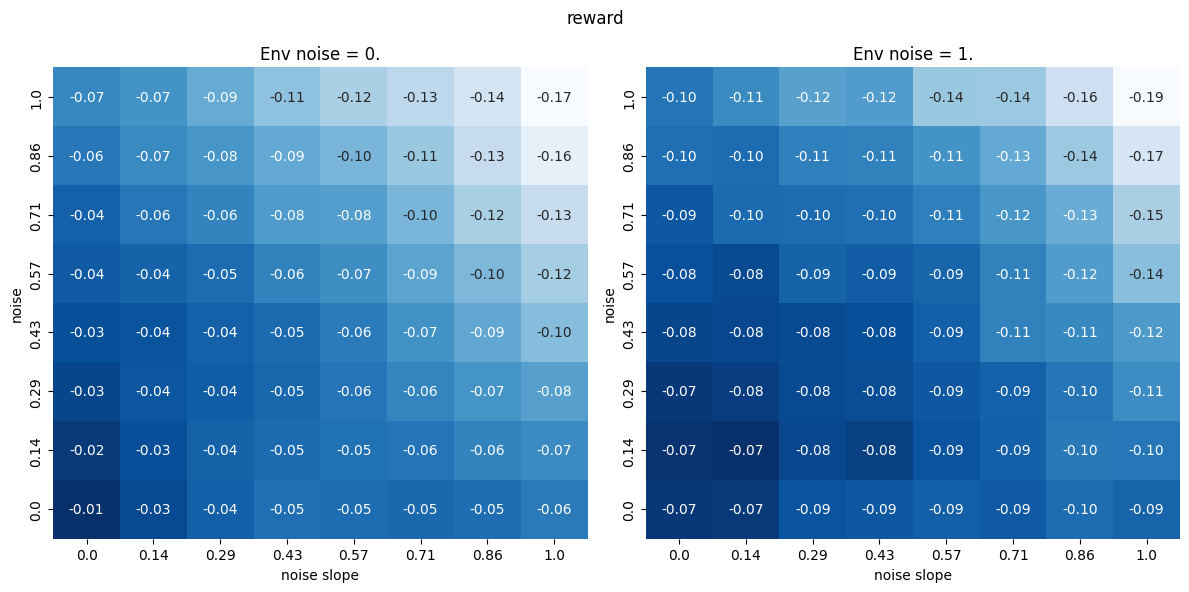

In [15]:
# plot reward
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_heat_map(eval_rwd_mean_1, ax[0], "noise slope", "noise")
plot_heat_map(eval_rwd_mean_2, ax[1], "noise slope", "noise")
ax[0].set_title("Env noise = 0.")
ax[1].set_title("Env noise = 1.")
plt.suptitle("reward")
plt.tight_layout()
plt.show()

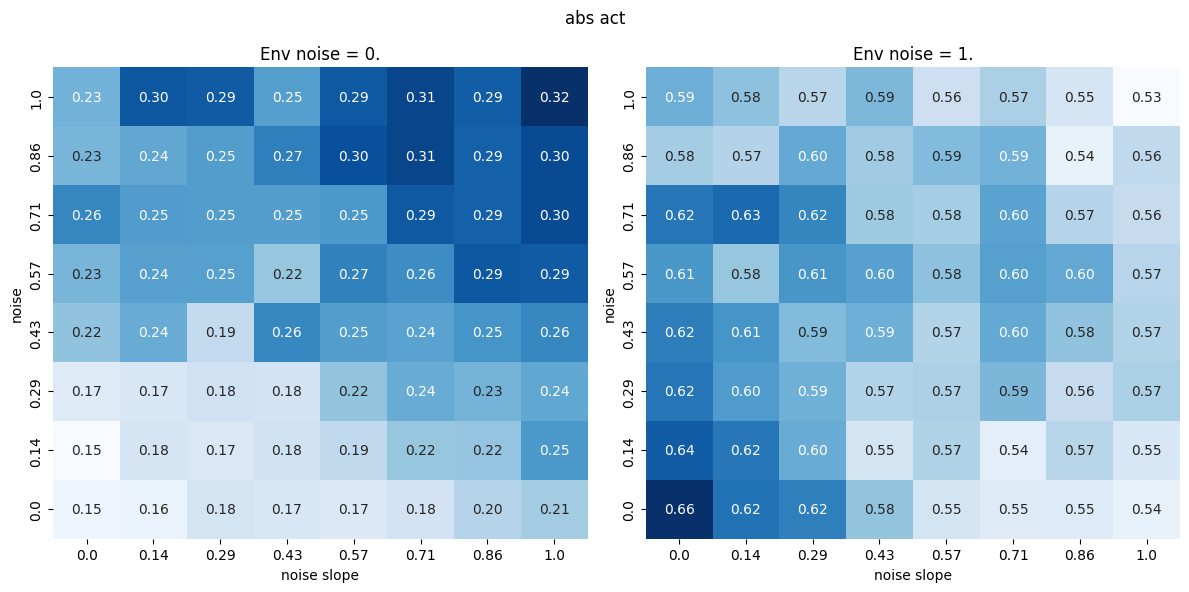

In [16]:
# plot action abs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_heat_map(eval_act_abs_1, ax[0], "noise slope", "noise")
plot_heat_map(eval_act_abs_2, ax[1], "noise slope", "noise")
ax[0].set_title("Env noise = 0.")
ax[1].set_title("Env noise = 1.")
plt.suptitle("abs act")
plt.tight_layout()
plt.show()

## Eval batch

In [17]:
def eval_teacher_batch(obs, teacher, teacher_noise, teacher_noise_slope, teacher_alpha):
    """Compute policy std on rollout obs"""
    conditioned_teacher = ConditionedTeacher(
        teacher, 
        noise_range=[teacher_noise, teacher_noise], 
        noise_slope_range=[teacher_noise_slope, teacher_noise_slope], 
        alpha_range=[teacher_alpha, teacher_alpha],
        alpha_apply_range=[0., 3.],
    )
    conditioned_teacher.reset()

    dist = conditioned_teacher.get_action_dist(obs)
    return dist.scale

In [18]:
env_noise = 0.5
env_noise_slope = 0.
teacher_noise = 0.
teacher_noise_slope = 0.
teacher_alpha = 1.

eval_rollout = eval_teacher_rollout(
    teacher,
    env_noise, 
    env_noise_slope,
    teacher_noise,
    teacher_noise_slope,
)

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 818.46item/s]


In [19]:
# batch eval
teacher_alpha = 1.

num_rows = 8
num_cols = 8
teacher_noises = torch.linspace(0., 1., steps=num_rows)
teacher_noise_slopes = torch.linspace(0., 1., steps=num_cols)

eval_batch_1 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_batch_1[i][j] = eval_teacher_batch(
            eval_rollout["obs"],
            teacher,
            teacher_noise,
            teacher_noise_slope,
            teacher_alpha,
        )

In [20]:
# batch eval
teacher_alpha = 3.

num_rows = 8
num_cols = 8
teacher_noises = torch.linspace(0., 1., steps=num_rows)
teacher_noise_slopes = torch.linspace(0., 1., steps=num_cols)

eval_batch_2 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_batch_2[i][j] = eval_teacher_batch(
            eval_rollout["obs"],
            teacher,
            teacher_noise,
            teacher_noise_slope,
            teacher_alpha,
        )

In [21]:
def compute_mean_scale(data):
    return data.mean().data.item()

eval_scale_mean_1 = compute_stats(eval_batch_1, compute_mean_scale)
eval_scale_mean_2 = compute_stats(eval_batch_2, compute_mean_scale)

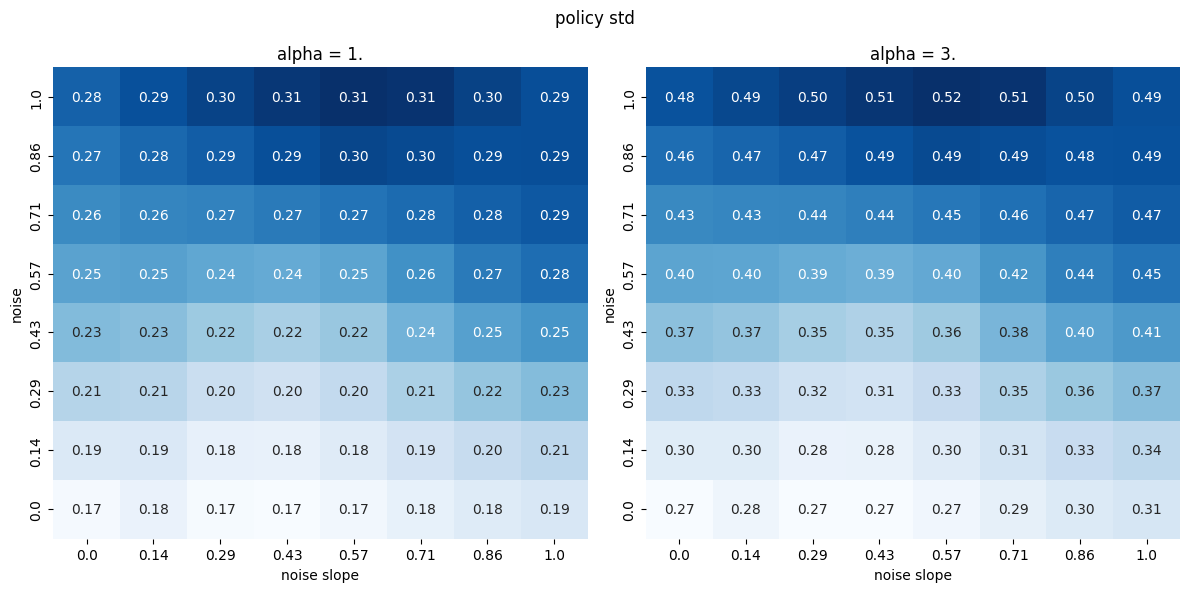

In [22]:
# plot policy std
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_heat_map(eval_scale_mean_1, ax[0], "noise slope", "noise")
plot_heat_map(eval_scale_mean_2, ax[1], "noise slope", "noise")
ax[0].set_title("alpha = 1.")
ax[1].set_title("alpha = 3.")
plt.suptitle("policy std")
plt.tight_layout()
plt.show()

## Deprecate

In [32]:
# umap state distributions
def normalize(x, mu, std):
    return (x - mu) / std

state_dim = 10 # robot pose, exclude goal pose
eval_states_1 = np.vstack([eval_data_1[i][0]["obs"]["observation"][..., :state_dim] for i in range(len(eval_data_1))])
eval_states_2 = np.vstack([eval_data_2[i][0]["obs"]["observation"][..., :state_dim] for i in range(len(eval_data_2))])
eval_state_labels_1 = np.vstack([np.ones_like(eval_data_1[i][0]["obs"]["observation"][..., :1]) * float(teacher_noises[i]) for i in range(len(eval_data_1))])
eval_state_labels_2 = np.vstack([np.ones_like(eval_data_2[i][0]["obs"]["observation"][..., :1]) * float(teacher_noises[i]) for i in range(len(eval_data_2))])

eval_states = np.vstack([eval_states_1, eval_states_2])

eval_states_norm = normalize(
    eval_states,
    eval_states.mean(0),
    eval_states.std(0),
)

print("eval state size", eval_states_norm.shape)

eval state size (60000, 10)


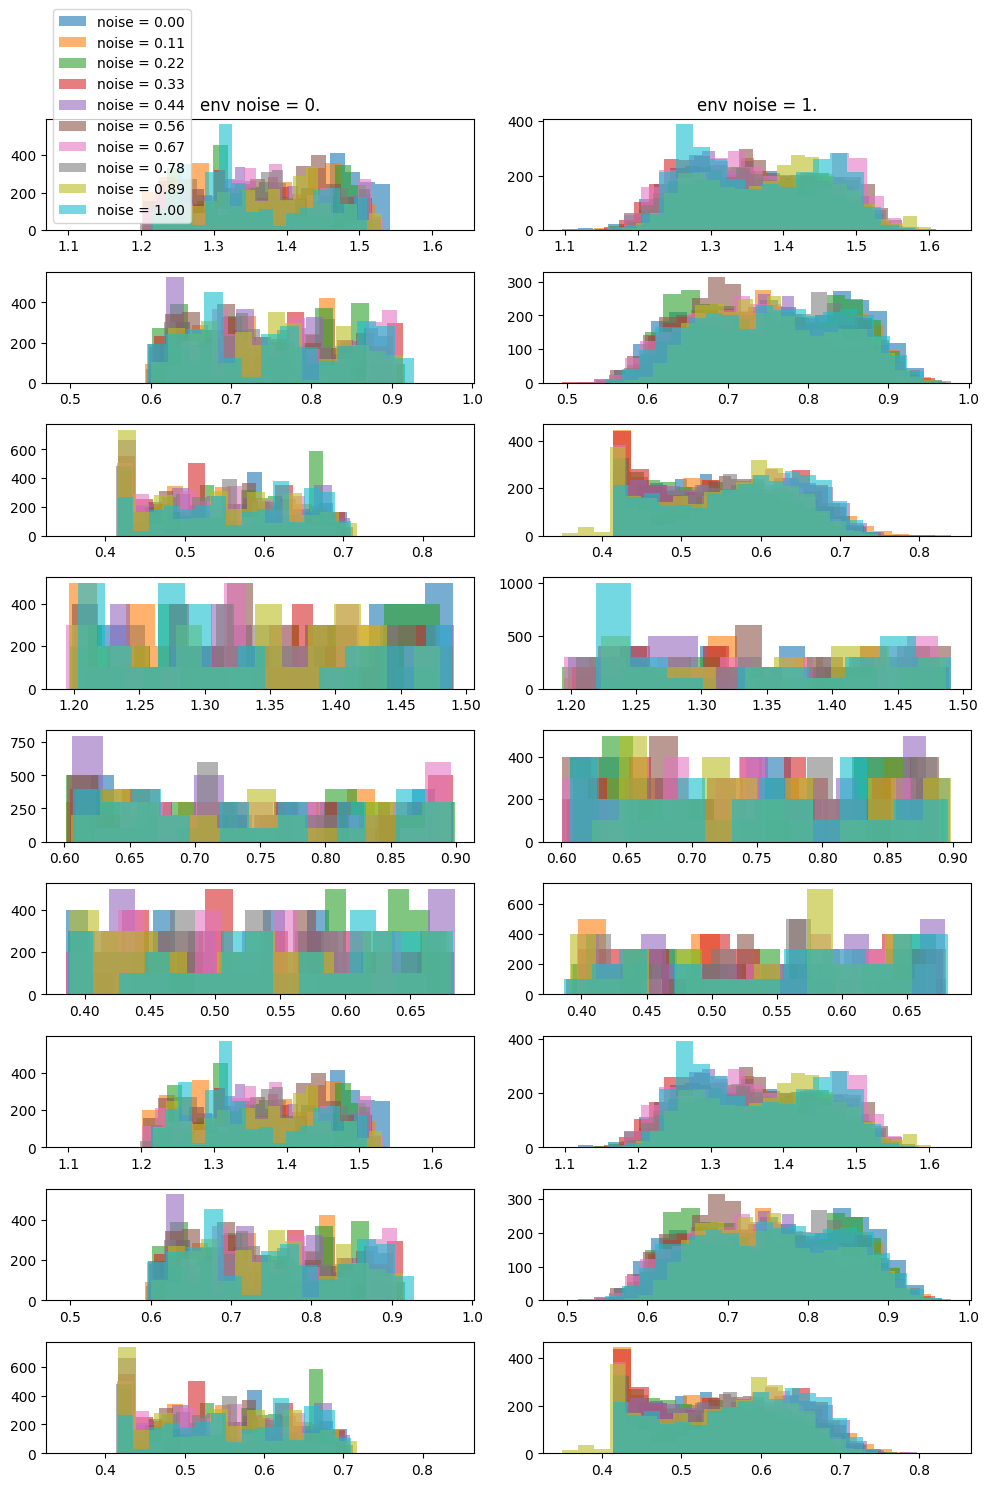

In [36]:
# plot state feature distributions
state_idxs = np.arange(state_dim - 1)
fig, ax = plt.subplots(len(state_idxs), 2, figsize=(10, 15), sharex="row")
for i, s in enumerate(state_idxs):
    for j in range(len(teacher_noises)):
        ax[i, 0].hist(eval_data_1[j][0]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="noise = {:.2f}".format(teacher_noises[j]))
        ax[i, 1].hist(eval_data_2[j][0]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="noise = {:.2f}".format(teacher_noises[j]))    
ax[0, 0].legend()
ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

plt.tight_layout()
plt.show()

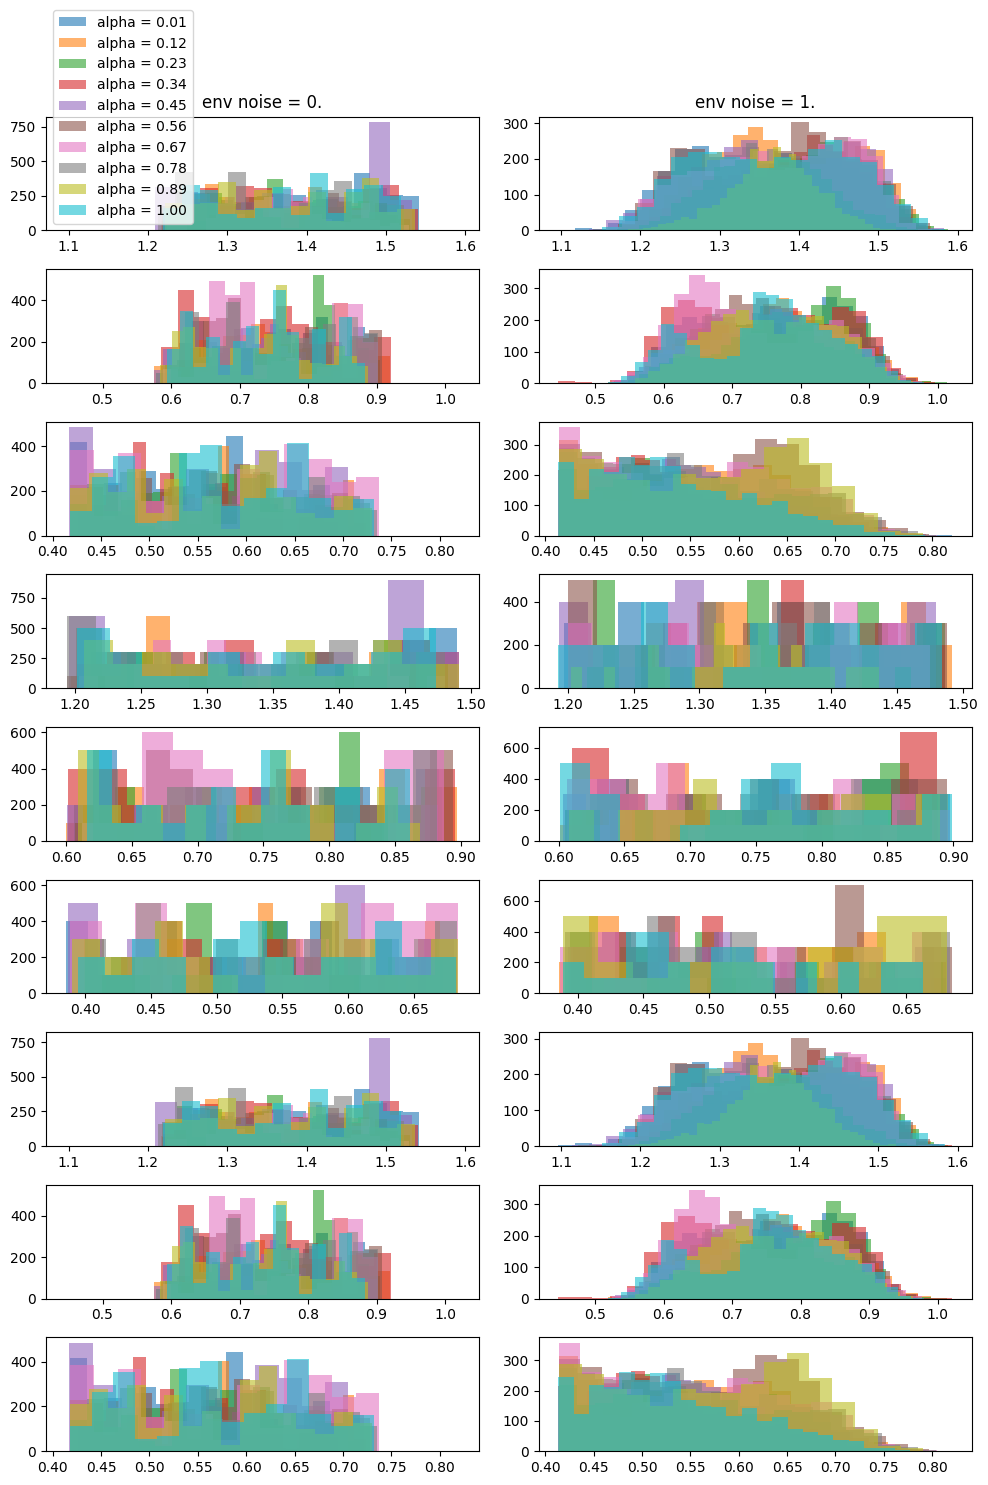

In [37]:
# plot state feature distributions
state_idxs = np.arange(state_dim - 1)
fig, ax = plt.subplots(len(state_idxs), 2, figsize=(10, 15), sharex="row")
for i, s in enumerate(state_idxs):
    for j in range(len(teacher_noise_slopes)):
        ax[i, 0].hist(eval_data_1[0][j]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="alpha = {:.2f}".format(teacher_alphas[j]))
        ax[i, 1].hist(eval_data_2[0][j]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="alpha = {:.2f}".format(teacher_alphas[j]))    
ax[0, 0].legend()
ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

plt.tight_layout()
plt.show()